### To view this notebook with interactive plots, follow [THIS LINK](http://nbviewer.jupyter.org/github/mferrari3/pyladies-stats/blob/master/pyladies_chapters.ipynb)

# Getting PyLadies chapter information.
PyLadies has many chapters listed on its webpage `https://www.pyladies.com/locations`. I would like to do some analytics to understand how each chapter interacts with its members.

## Download requirements.
I will use the API provided by Meetup, which I install via the following:
``` shell
pip install meetup-api
```

## Import relevant packages.

In [1]:
import requests
import random
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from datetime import datetime
import meetup.api
import plotly.plotly as py
import ipywidgets
from ipywidgets import interactive, fixed, widgets

import matplotlib
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
font = {'family' : 'sans-serif',
        'size'   : 16}

matplotlib.rc('font', **font)

## Scrape the PyLadies website for chapters and social media links.

In [3]:
pyladies_request = requests.get('https://www.pyladies.com/locations')
pyladies_soup = BeautifulSoup(pyladies_request.text, 'html.parser')

In [4]:
all_chapters = pyladies_soup.find_all(class_="chapter_location")
print('There are {} PyLadies chapters listed on the PyLadies website'.format(len(all_chapters)))

There are 84 PyLadies chapters listed on the PyLadies website


#### Determine social media links.

For a given chapter, we can access the information on the website by looking at the html code:

In [5]:
ix = 5
single_chapter = all_chapters[ix]
single_chapter

<div class="chapter_location" data-chapter-name="Australia" data-meetup-id="">
<div class="logo-container">
<img alt="Australia" src="../assets/images/pyladies_australia.png"/>
</div>
<h3 class="chpts chapter-name">
<a href="/locations/http://australia.pyladies.com/">
                            
                            Australia</a>
</h3>
<h3 class="chpts social-icons">
<a class="social icon link" data-icon="🔗" href="http://australia.pyladies.com/" title="Website"></a>
<a class="social icon vcard" data-icon="" href="/cdn-cgi/l/email-protection#35544046414754595c5475454c5954515c50461b565a58" title="Contact"></a>
<a class="social icon facebook" data-icon="" href="https://www.facebook.com/pyladiesau" title"facebook"=""></a>
<a class="social icon github" data-icon="" href="https://github.com/PyLadiesAU" title"github"=""></a>
<a class="social icon twitter" data-icon="" href="https://twitter.com/pyladiesau" title="Twitter"></a>
</h3>
</div>

Lets look at the social media links for a given chapter:

In [6]:
social_links = single_chapter.find_all('a', attrs={"class":"social"})
social_links

[<a class="social icon link" data-icon="🔗" href="http://australia.pyladies.com/" title="Website"></a>,
 <a class="social icon vcard" data-icon="" href="/cdn-cgi/l/email-protection#35544046414754595c5475454c5954515c50461b565a58" title="Contact"></a>,
 <a class="social icon facebook" data-icon="" href="https://www.facebook.com/pyladiesau" title"facebook"=""></a>,
 <a class="social icon github" data-icon="" href="https://github.com/PyLadiesAU" title"github"=""></a>,
 <a class="social icon twitter" data-icon="" href="https://twitter.com/pyladiesau" title="Twitter"></a>]

In [7]:
social_platforms = set([])
bad_links = []
for single_chapter in all_chapters:
    social_links = single_chapter.find_all('a', attrs={"class":"social"})
    for social_link in social_links:
        if social_link.has_attr("title"):
            social_platforms.add(social_link['title'])
        else:
            bad_links.append(social_link)
print(f'The social platforms found: {social_platforms}\n')
print(f'There were {len(bad_links)} links without a title attribute. A sample bad link is: \n{random.choice(bad_links)}')

The social platforms found: {'Timepad Link', 'Meetup Link', 'Website', 'Twitter', 'Contact'}

There were 52 links without a title attribute. A sample bad link is: 
<a class="social icon facebook" data-icon="" href="https://www.facebook.com/PyLadiesTeresina" title"facebook"=""></a>


### Pull Request!

Here is where I noticed that the `title` attribute for social media links corresponding to Facebook, Google+, and Github had syntax errors. I created a Pull Request for the PyLadies website to fix this:

```html 
<!-- BEFORE -->
<a class="social icon github" title"github"=""></a>

<!-- AFTER -->
<a class="social icon github" title="github"></a>
```

While the HTML code is getting fixed, we can access the social link by the `class` attribute.

In [8]:
social_link.attrs

{'class': ['social', 'icon', 'vcard'],
 'data-icon': '\ue722',
 'href': '/cdn-cgi/l/email-protection#97edf6e5fef6d7e7eefbf6f3fef2e4b9f4f8fa',
 'title': 'Contact'}

In [9]:
social_link['class'][-1]

'vcard'

In [10]:
social_platforms = set([])
for single_chapter in all_chapters:
    social_links = single_chapter.find_all('a', attrs={"class":"social"})
    for social_link in social_links:
        social_platforms.add(social_link['class'][-1])
print(f'The social platforms found: {social_platforms}')

The social platforms found: {'location', 'twitter', 'facebook', 'link', 'vcard', 'github', 'google-plus'}


Note that for class description: 
- `link = website link` 
- `location = Meetup Link`, expect when `location = Timepad Link` for PyLadies St. Petersburg.

In [11]:
social_platforms = set([])
bad_links = []
for single_chapter in all_chapters:
    social_links = single_chapter.find_all('a', attrs={"class":"social"})
    for social_link in social_links:
        if social_link.has_attr("title"):
            social_platforms.add(social_link['title'])
        else:
            social_platforms.add(social_link['class'][-1])
print(f'The social platforms found: \n{social_platforms}')

The social platforms found: 
{'Timepad Link', 'facebook', 'github', 'Meetup Link', 'Website', 'Twitter', 'Contact', 'google-plus'}


In [12]:
chapter_info = pd.DataFrame(columns=social_platforms)

for chapter_id, single_chapter in enumerate(all_chapters):
    chapter_dict = {}
    social_links = single_chapter.find_all('a', attrs={"class":"social"})
    chapter_dict['chapter_id'] = chapter_id
    chapter_name = single_chapter.find("h3", class_="chpts chapter-name").find("a").text.strip()
    chapter_dict['chapter_name'] = chapter_name
    for social_link in social_links:
        if social_link.has_attr("title"):
            chapter_dict[social_link['title']] = social_link['href']
        else:
            chapter_dict[social_link['class'][-1]] = social_link['href']
    chapter_info = chapter_info.append(chapter_dict, ignore_index=True)
    
chapter_info['chapter_id'] = chapter_info['chapter_id'].astype('int')
chapter_info = chapter_info.set_index(['chapter_id', 'chapter_name'])
chapter_info.head()

,,Timepad Link,facebook,github,Meetup Link,Website,Twitter,Contact,google-plus
chapter_id,chapter_name,,,,,,,,
0,"Amsterdam, the Netherlands",NaN,NaN,NaN,http://www.meetup.com/PyLadiesAMS/,amsterdam,https://twitter.com/PyLadiesAMS,/cdn-cgi/l/email-protection#67060a141302150306...,NaN
1,"Antananarivo, MDG",NaN,NaN,NaN,NaN,tnr,https://twitter.com/PyladiesMDG,/cdn-cgi/l/email-protection#3743594577474e5b56...,NaN
2,"Aracati, Brazil",NaN,NaN,NaN,http://www.meetup.com/PyladeisAracati/,NaN,https://twitter.com/PyladiesAracati,/cdn-cgi/l/email-protection#fa9b889b999b8e93ba...,NaN
3,"Atlanta, GA",NaN,NaN,NaN,http://www.meetup.com/pyladiesATL/,atl,https://twitter.com/pyladiesATL,/cdn-cgi/l/email-protection#6706130b27171e0b06...,NaN
4,"Austin, TX",NaN,NaN,NaN,http://www.meetup.com/pyladies-atx/,atx,https://twitter.com/pyladiesATX,/cdn-cgi/l/email-protection#6d0c19152d1d14010c...,NaN


In [13]:
chapter_info = pd.read_csv('chapter_info.gz', compression='gzip')
chapter_info = chapter_info.set_index(['chapter_id', 'chapter_name'])

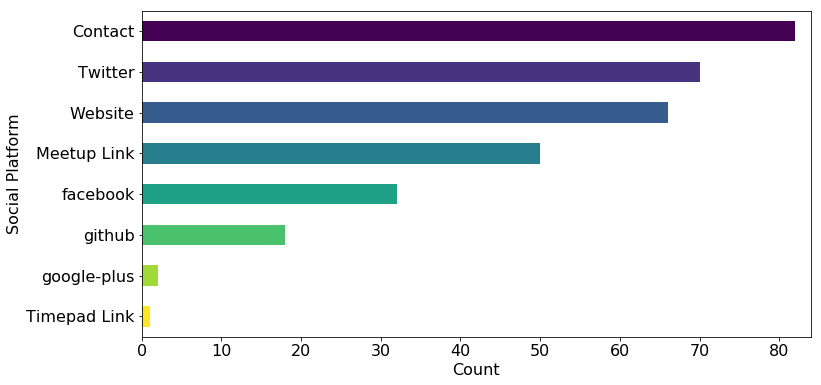

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
color = matplotlib.cm.viridis_r(np.linspace(0, 1, len(chapter_info.columns)))
chapter_info.count().sort_values().plot(kind='barh', ax=ax, color=color);
ax.set_xlim(right=chapter_info.index.get_level_values(level='chapter_id').max()+1);
ax.set_ylabel('Social Platform') ; ax.set_xlabel('Count');

In [3]:
#chapter_info.to_csv('chapter_info.gz', compression='gzip')
#chapter_info = pd.read_csv('chapter_info.gz', compression='gzip')

## Open Question:
1. Determine which social platform is used across state, country, continent

## Meetup.
I will be working with the Meetup API. To get your own API key, just go to the [Meetup API Website](https://www.meetup.com/meetup_api/)

In [190]:
client = meetup.api.Client()
client.api_key = 'insert-your-key-here'

In [17]:
chapter_meetups = chapter_info[['Meetup Link']]
chapter_meetups.head()

,,Meetup Link
chapter_id,chapter_name,
0,"Amsterdam, the Netherlands",http://www.meetup.com/PyLadiesAMS/
1,"Antananarivo, MDG",NaN
2,"Aracati, Brazil",http://www.meetup.com/PyladeisAracati/
3,"Atlanta, GA",http://www.meetup.com/pyladiesATL/
4,"Austin, TX",http://www.meetup.com/pyladies-atx/


In [18]:
meetup_api_cols = ['meetup_name', 'group_id', 'status', 'meetup_members', 'date_created',
                   'country', 'state', 'city', 'timezone', 'longitude', 'latitude', 
                   'num_future', 'num_past', 'num_past_scraped', 'next_meetup', 'last_meetup', 'last_meetup_rsvp']

In [19]:
chapter_meetups = pd.concat([chapter_meetups, pd.DataFrame(columns=meetup_api_cols)], sort=False)

In [20]:
chapter_meetups.columns

Index(['Meetup Link', 'meetup_name', 'group_id', 'status', 'meetup_members',
       'date_created', 'country', 'state', 'city', 'timezone', 'longitude',
       'latitude', 'num_future', 'num_past', 'num_past_scraped', 'next_meetup',
       'last_meetup', 'last_meetup_rsvp'],
      dtype='object')

In [21]:
chapter_meetups.head()

,,Meetup Link,meetup_name,group_id,status,meetup_members,date_created,country,state,city,timezone,longitude,latitude,num_future,num_past,num_past_scraped,next_meetup,last_meetup,last_meetup_rsvp
chapter_id,chapter_name,,,,,,,,,,,,,,,,,,
0,"Amsterdam, the Netherlands",http://www.meetup.com/PyLadiesAMS/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Antananarivo, MDG",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Aracati, Brazil",http://www.meetup.com/PyladeisAracati/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Atlanta, GA",http://www.meetup.com/pyladiesATL/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Austin, TX",http://www.meetup.com/pyladies-atx/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
for ix, row in chapter_meetups.iterrows():
    
    meetup_url = row['Meetup Link']
    if not pd.isnull(meetup_url):
        row_request = requests.get(meetup_url)
        if row_request.status_code != 200:
            pass
        else:
            
            print(meetup_url)
            
            ## Get the Meetup Group details.
            group_info = client.GetGroup({'urlname': meetup_url.split('meetup.com/')[1]})

            date_created = datetime.fromtimestamp(group_info.created/1000.0)

            ## Get all future and past events.
            future_activity = client.GetEvents(group_id = group_info.id)
            past_activity = client.GetEvents(group_id = group_info.id, status='past')

            num_future = future_activity.meta['total_count']            
            num_past = past_activity.meta['total_count']

            ## I found that the number of past events wasn't always accurate with the API, so I also find it using web scraping.
            row_soup = BeautifulSoup(row_request.text, 'html.parser')
            events = row_soup.find_all(class_="text--sectionTitle text--bold padding--bottom")
            num_past_scraped = int([f for f in events if "Past" in str(f)][0].text.split('(')[1].split(')')[0])
            
            if num_future > 0:
                next_date = datetime.fromtimestamp(future_activity.results[0]['time']/1000.0)  
            else:
                next_date = np.nan
                
            if num_past == 0 and num_past_scraped != 0: 
                last_date = datetime.fromtimestamp(int(row_soup.find_all("time", class_="")[0]['datetime'])/1000.0) 
                yes_rsvp = int(row_soup.find_all("li", class_="avatarRow--attendingCount display--inline text--small text--secondary")[0].text.split(' ')[0])
            elif num_past > 0:
                last_date = datetime.fromtimestamp(past_activity.results[-1]['time']/1000.0)
                yes_rsvp = past_activity.results[-1]['yes_rsvp_count']
            else: 
                last_date = np.nan
                yes_rsvp = np.nan 
                
            chapter_meetups.loc[ix, meetup_api_cols] = [group_info.name, group_info.id, group_info.status, group_info.members, date_created,
                                                        group_info.country, group_info.state, group_info.city, group_info.timezone, 
                                                        group_info.lon, group_info.lat,
                                                        num_future, num_past, num_past_scraped, next_date, last_date, yes_rsvp]

http://www.meetup.com/PyLadiesAMS/
29/30 (10 seconds remaining)
28/30 (10 seconds remaining)
27/30 (10 seconds remaining)
http://www.meetup.com/pyladies-atx/
26/30 (1 seconds remaining)
25/30 (1 seconds remaining)
24/30 (1 seconds remaining)
http://www.meetup.com/PyLadies-BH-Meetup/
29/30 (10 seconds remaining)
28/30 (10 seconds remaining)
27/30 (10 seconds remaining)
http://www.meetup.com/PyLadies-Berlin/
26/30 (9 seconds remaining)
25/30 (9 seconds remaining)
24/30 (9 seconds remaining)
http://www.meetup.com/PyLadies-Boston/
23/30 (7 seconds remaining)
22/30 (7 seconds remaining)
21/30 (7 seconds remaining)
http://www.meetup.com/pyladiescz/
20/30 (4 seconds remaining)
19/30 (4 seconds remaining)
18/30 (4 seconds remaining)
http://www.meetup.com/Chicago-PyLadies/
29/30 (10 seconds remaining)
28/30 (10 seconds remaining)
27/30 (10 seconds remaining)
http://www.meetup.com/PyLadiesDublin/
26/30 (7 seconds remaining)
25/30 (6 seconds remaining)
24/30 (6 seconds remaining)
http://www.meetu

In [26]:
#chapter_meetups.to_csv('chapter_meetups.gz', compression='gzip')
chapter_meetups = pd.read_csv('chapter_meetups.gz', compression='gzip', index_col=0)

In [27]:
chapter_meetups.dropna(subset=['Meetup Link'])

,,Meetup Link,meetup_name,group_id,status,meetup_members,date_created,country,state,city,timezone,longitude,latitude,num_future,num_past,num_past_scraped,next_meetup,last_meetup,last_meetup_rsvp
chapter_id,chapter_name,,,,,,,,,,,,,,,,,,
0,"Amsterdam, the Netherlands",http://www.meetup.com/PyLadiesAMS/,PyLadies Amsterdam,9301202,active,304,2013-07-10 15:49:40,NL,,Amsterdam,Europe/Amsterdam,4.89,52.37,0,13,13,NaN,2015-12-10 12:00:00,18
2,"Aracati, Brazil",http://www.meetup.com/PyladeisAracati/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Atlanta, GA",http://www.meetup.com/pyladiesATL/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Austin, TX",http://www.meetup.com/pyladies-atx/,PyLadies ATX,5947662,active,1041,2012-11-21 16:52:24,US,TX,Austin,US/Central,-97.76,30.24,14,187,189,2018-12-17 20:00:00,2018-11-27 19:30:00,12
6,"Bangalore, India",http://www.meetup.com/PyladiesBangalore/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"Belo Horizonte, Brazil",http://www.meetup.com/PyLadies-BH-Meetup/,PyLadies BH Meetup,18890724,active,195,2015-09-01 20:52:48,BR,,Belo Horizonte,America/Sao_Paulo,-43.94,-19.92,0,2,2,NaN,2016-05-21 13:00:00,11
10,"Berlin, Germany",http://www.meetup.com/PyLadies-Berlin/,PyLadies Berlin,8623152,active,1180,2013-05-24 07:27:07,DE,,Berlin,Europe/Berlin,13.38,52.52,0,68,69,NaN,2018-12-11 13:00:00,79
13,"Boston, MA",http://www.meetup.com/PyLadies-Boston/,PyLadies Boston,8401402,active,1248,2013-05-08 12:07:37,US,MA,Boston,US/Eastern,-71.06,42.36,0,0,199,NaN,2018-09-27 18:00:00,17
16,"Brno, Czech Republic",http://www.meetup.com/pyladiescz/,PyWorking Sessions - Praha,5160912,active,309,2012-09-29 09:17:01,CZ,,Prague,Europe/Prague,14.43,50.08,0,48,49,NaN,2018-12-17 12:00:00,13


### Inactive Meetups.
The following meetup links are listed on the PyLadies website, but have do not have an active status on Meetup.

In [30]:
innactive_meetups = chapter_meetups.dropna(subset=['Meetup Link'])[chapter_meetups.dropna(subset=['Meetup Link'])['status'].isnull()][['Meetup Link']]
innactive_meetups

,,Meetup Link
chapter_id,chapter_name,
2,"Aracati, Brazil",http://www.meetup.com/PyladeisAracati/
3,"Atlanta, GA",http://www.meetup.com/pyladiesATL/
6,"Bangalore, India",http://www.meetup.com/PyladiesBangalore/
19,"Caxias do Sul, Brazil",http://www.meetup.com/PyLadiesCaxiasdoSul/
20,"Charleston, SC",http://www.meetup.com/PyLadies-Charleston/
23,"Dallas, TX",http://www.meetup.com/dfw-pyladies/
32,"Ho Chi Minh, Vietnam",http://www.meetup.com/hcmc-pyladies/
35,"Kampala, Uganda",http://www.meetup.com/pyladies-kampala/
41,"Maceio, Brazil",http://www.meetup.com/Maceio PyLadies/


In [36]:
print('The following Meetup pages are innactive:\n')
print('\n'.join('{}'.format(item) for item in innactive_meetups.index.get_level_values(1)))

The following Meetup pages are innactive:

Aracati, Brazil
Atlanta, GA
Bangalore, India
Caxias do Sul, Brazil
Charleston, SC
Dallas, TX
Ho Chi Minh, Vietnam
Kampala, Uganda
Maceio, Brazil
Milan, Italy
Nashville, TN
Nigeria
Ojere, NG
Salvador, Brazil
Singapore


## Open Questions:
1. Are innactive Meetup groups using another form of social media to advertise their events?

### Meetup Statistics.

In [37]:
print('There are {} PyLadies members on Meetup in {} different countries'.format(int(chapter_meetups['meetup_members'].sum()), chapter_meetups.country.nunique()))

There are 30415 PyLadies members on Meetup in 15 different countries


In [38]:
print('There have been {} PyLadies events through Meetup'.format(int(chapter_meetups['num_past_scraped'].sum())))

There have been 2836 PyLadies events through Meetup


In [39]:
## Meetups sorted by number of members
chapter_meetups.sort_values('meetup_members', ascending=False).head(n=10)

,,Meetup Link,meetup_name,group_id,status,meetup_members,date_created,country,state,city,timezone,longitude,latitude,num_future,num_past,num_past_scraped,next_meetup,last_meetup,last_meetup_rsvp
chapter_id,chapter_name,,,,,,,,,,,,,,,,,,
64,"San Francisco, CA",http://www.meetup.com/pyladiessf/,PyLadies of San Francisco,3604052,active,5266,2012-04-04 01:45:48,US,CA,San Francisco,US/Pacific,-122.4,37.77,50,403,411,2018-12-20 21:00:00,2016-04-16 16:00:00,22
49,"New York, NY",http://www.meetup.com/nyc-pyladies/,NYC PyLadies,4576312,active,3334,2012-08-17 23:23:50,US,NY,New York,US/Eastern,-73.99,40.75,1,127,130,2018-12-17 18:30:00,2018-12-06 18:30:00,53
66,"Seattle, WA",http://www.meetup.com/seattle-pyladies/,Seattle PyLadies,5411282,active,1735,2012-10-15 22:11:50,US,WA,Seattle,US/Pacific,-122.29,47.68,46,248,248,2019-01-07 20:00:00,2017-11-13 20:15:00,15
38,"London, UK",http://www.meetup.com/pyladieslondon/,PyLadies London,13320732,active,1621,2014-03-13 06:58:57,GB,17,London,Europe/London,-0.13,51.51,0,58,58,NaN,2018-12-12 13:00:00,15
73,Taiwan,http://www.meetup.com/PyLadiesTW/,PyLadies Taiwan,13106102,active,1502,2014-02-28 04:15:53,TW,,Taipei,Asia/Taipei,121.45,25.02,0,77,77,NaN,2018-11-18 01:00:00,1
13,"Boston, MA",http://www.meetup.com/PyLadies-Boston/,PyLadies Boston,8401402,active,1248,2013-05-08 12:07:37,US,MA,Boston,US/Eastern,-71.06,42.36,0,0,199,NaN,2018-09-27 18:00:00,17
56,"Pune, India",http://www.meetup.com/PyLadies-Pune/,PyLadies Pune,17516492,active,1199,2014-10-09 16:45:55,IN,,Pune,Asia/Calcutta,73.84,18.53,0,17,17,NaN,2017-11-19 00:30:00,17
10,"Berlin, Germany",http://www.meetup.com/PyLadies-Berlin/,PyLadies Berlin,8623152,active,1180,2013-05-24 07:27:07,DE,,Berlin,Europe/Berlin,13.38,52.52,0,68,69,NaN,2018-12-11 13:00:00,79
82,"Washington, DC",http://www.meetup.com/dc-pyladies/,DC PyLadies,2292131,active,1142,2011-08-04 18:16:56,US,DC,Washington,US/Eastern,-77.02,38.95,0,80,80,NaN,2018-08-04 13:00:00,25


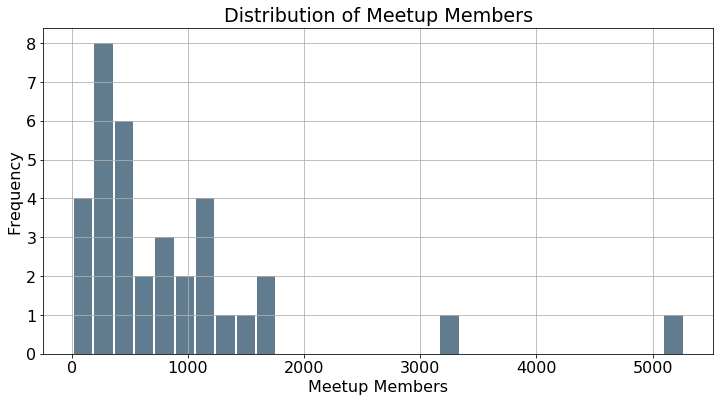

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))
chapter_meetups.dropna(subset=["status"])['meetup_members'].astype('int').hist(grid=True, bins=30, rwidth=0.9, color='#607c8e', ax=ax);
ax.set_xlabel('Meetup Members'); ax.set_ylabel('Frequency');
ax.set_title('Distribution of Meetup Members');

### Filter out US Meetup Groups.

In [72]:
US_groups = chapter_meetups[chapter_meetups.country == 'US'][['meetup_name', 'date_created', 'meetup_members', 'num_past_scraped', 'longitude', 'latitude']].copy()

In [73]:
US_groups.head()

,,meetup_name,date_created,meetup_members,num_past_scraped,longitude,latitude
chapter_id,chapter_name,,,,,,
4,"Austin, TX",PyLadies ATX,2012-11-21 16:52:24,1041,189,-97.76,30.24
13,"Boston, MA",PyLadies Boston,2013-05-08 12:07:37,1248,199,-71.06,42.36
21,"Chicago, IL",Chicago PyLadies,2015-01-10 13:59:44,1110,70,-87.63,41.88
28,"Grand Rapids, MI",PyLadies Grand Rapids,2017-02-06 14:51:32,123,24,-85.66,42.96
33,"Houston, TX",Houston PyLadies,2014-07-08 12:03:03,350,28,-95.4,29.77


In [81]:
US_groups['text'] = US_groups['meetup_name'].astype(str) +\
                    '<br>Created: ' + (US_groups['date_created']).astype(str) +\
                    '<br>Members: ' + (US_groups['meetup_members'].astype(int)).astype(str) +\
                    '<br>Past Meetups: ' + (US_groups['num_past_scraped'].astype(int)).astype(str) 
scale = US_groups.meetup_members.max()

chapters = dict(
    type = 'scattergeo',
    locationmode = 'USA-states',
    lon = US_groups['longitude'],
    lat = US_groups['latitude'],
    text = US_groups['text'],
    marker = dict(
        size = US_groups['meetup_members']/scale,
        sizeref = 2. * max(US_groups['meetup_members']/scale) / (50 ** 2),
        color = US_groups['meetup_members'],
        colorscale='Viridis',
        colorbar=dict(title='Number of Members'),
        line = dict(color='rgb(40,40,40)', width=2),
        sizemode = 'area'),  #'area', 'diameter'
    )

layout = dict(
        autosize=False,
        width = 1400,
        height=800,
        title = 'PyLadies Meetup Members<br>(USA Locations)',
        geo = dict(
            scope='usa', #"world" | "usa" | "europe" | "asia" | "africa" | "north america" | "south america"
            projection=dict( type='albers usa' ), #type = 'Mercator'type='albers usa'
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict(data=[chapters], layout=layout)
py.iplot(fig, validate=False, filename='d3-bubble-map-meetup_members_US')

In [90]:
chapter_meetups['text'] = chapter_meetups['meetup_name'] +\
                            '<br>Created: ' + (chapter_meetups['date_created']).astype(str) +\
                            '<br>Members ' + (chapter_meetups['meetup_members']).astype(str) +\
                            '<br>Past Meetups ' + (chapter_meetups['num_past_scraped']).astype(str)
scale = chapter_meetups.meetup_members.max()

chapters = dict(
    type = 'scattergeo',
    lon = chapter_meetups['longitude'],
    lat = chapter_meetups['latitude'],
    text = chapter_meetups['text'],
    marker = dict(
        size = chapter_meetups['meetup_members']/scale,
        sizeref = 2. * max(chapter_meetups['meetup_members']/scale) / (50 ** 2),
        color = chapter_meetups['meetup_members'],
        colorscale='Viridis',
        colorbar=dict(title='Number of Members'),
        line = dict(color='rgb(40,40,40)', width=2),
        sizemode = 'area'),  #'area', 'diameter'
    )

layout = dict(
        autosize=False,
        width=1400,
        height=800,
        title = 'PyLadies Meetup Members<br>Worldwide',
        geo = dict(
            scope='world', #"world" | "usa" | "europe" | "asia" | "africa" | "north america" | "south america"
            projection=dict( type='Mercator' ), #type = 'Mercator'type='albers usa'
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict(data=[chapters], layout=layout)
py.iplot(fig, validate=False, filename='d3-bubble-map-meetup_members_worldwide')

# Meetup events.

In [83]:
chapter_meetups = pd.read_csv('chapter_meetups.gz', compression='gzip', index_col=0)

In [84]:
chapter_meetups.columns

Index(['chapter_name', 'Meetup Link', 'meetup_name', 'group_id', 'status',
       'meetup_members', 'date_created', 'country', 'state', 'city',
       'timezone', 'longitude', 'latitude', 'num_future', 'num_past',
       'num_past_scraped', 'next_meetup', 'last_meetup', 'last_meetup_rsvp'],
      dtype='object')

In [85]:
active_meetups = chapter_meetups.dropna(subset=['Meetup Link', 'status'])[['Meetup Link', 'group_id', 'country', 'state', 'city', 'date_created']]
active_meetups.head()

,Meetup Link,group_id,country,state,city,date_created
chapter_id,,,,,,
0,http://www.meetup.com/PyLadiesAMS/,9301202.0,NL,NaN,Amsterdam,2013-07-10 15:49:40
4,http://www.meetup.com/pyladies-atx/,5947662.0,US,TX,Austin,2012-11-21 16:52:24
9,http://www.meetup.com/PyLadies-BH-Meetup/,18890724.0,BR,NaN,Belo Horizonte,2015-09-01 20:52:48
10,http://www.meetup.com/PyLadies-Berlin/,8623152.0,DE,NaN,Berlin,2013-05-24 07:27:07
13,http://www.meetup.com/PyLadies-Boston/,8401402.0,US,MA,Boston,2013-05-08 12:07:37


In [86]:
meetup_event_cols = ['urlname', 'venue', 'rsvp_limit', 'waitlist_count', 'description', 'event_url', 
                     'yes_rsvp_count', 'duration', 'announced', 'name', 'id', 'time']

In [91]:
df_events = pd.DataFrame(columns=meetup_event_cols + list(active_meetups.columns))
df_events

,urlname,venue,rsvp_limit,waitlist_count,description,event_url,yes_rsvp_count,duration,announced,name,id,time,Meetup Link,group_id,country,state,city,date_created


In [127]:
for ix, row in active_meetups.loc[0:].iterrows():

    meetup_url = row['Meetup Link']
    if not pd.isnull(meetup_url):
        print(meetup_url)

        ## Get the Meetup Group details.
        group_info = client.GetGroup({'urlname': meetup_url.split('meetup.com/')[1]})
        
        try: 
            group_info.errors[0]['code'] == 'group_error'
            print('Error for: {}'.format(meetup_url))
            pass
        except:
            ## Get all future and past events.
            future_activity = client.GetEvents(group_id = group_info.id)
            past_activity = client.GetEvents(group_id = group_info.id, status='past')

            for activity in past_activity.results:
                urlname = activity['group']['urlname']
                data = [urlname]
                for col in meetup_event_cols[1:]:
                    data.append(activity.get(col))
                data.extend(row.values)

                df_events = df_events.append(pd.DataFrame(columns=meetup_event_cols + list(active_meetups.columns), 
                                                          data=[data]), ignore_index=True)

                
df_events['time'] = df_events['time'].apply(lambda x: datetime.fromtimestamp(x/1000.0))

http://www.meetup.com/PyLadies-Vancouver/
20/30 (3 seconds remaining)
19/30 (3 seconds remaining)
18/30 (3 seconds remaining)
http://www.meetup.com/pyladies-vienna/
17/30 (3 seconds remaining)
16/30 (2 seconds remaining)
15/30 (2 seconds remaining)
http://www.meetup.com/dc-pyladies/
14/30 (2 seconds remaining)
13/30 (2 seconds remaining)
12/30 (2 seconds remaining)


In [160]:
df_events = df_events.drop_duplicates(subset=['event_url', 'id'], keep='first').copy()

In [168]:
#df_events.to_csv('event_info.gz', compression='gzip')
df_events = pd.read_csv('event_info.gz', compression='gzip', index_col=0)

In [170]:
df_events.columns

Index(['urlname', 'venue', 'rsvp_limit', 'waitlist_count', 'description',
       'event_url', 'yes_rsvp_count', 'duration', 'announced', 'name', 'id',
       'time', 'Meetup Link', 'group_id', 'country', 'state', 'city',
       'date_created'],
      dtype='object')

In [171]:
df_events.head()

,urlname,venue,rsvp_limit,waitlist_count,description,event_url,yes_rsvp_count,duration,announced,name,id,time,Meetup Link,group_id,country,state,city,date_created
0,PyLadiesAMS,"{'country': 'nl', 'localized_country_name': 'N...",NaN,0,"<p>Hi Girls,</p> <p>Due to extreme weather con...",https://www.meetup.com/PyLadiesAMS/events/1289...,6,NaN,NaN,PyLadies Amsterdam Launch Event,128930682,2013-07-29 13:00:00,http://www.meetup.com/PyLadiesAMS/,9301202.0,NL,NaN,Amsterdam,2013-07-10 15:49:40
1,PyLadiesAMS,"{'country': 'nl', 'localized_country_name': 'N...",NaN,0,"<p>Since there are some new members, we are go...",https://www.meetup.com/PyLadiesAMS/events/1406...,9,NaN,NaN,Socialize Meet and Greet,140665992,2013-09-24 13:00:00,http://www.meetup.com/PyLadiesAMS/,9301202.0,NL,NaN,Amsterdam,2013-07-10 15:49:40
2,PyLadiesAMS,"{'country': 'nl', 'localized_country_name': 'N...",NaN,0,<p>Hi everyone! We're glad to announce that ou...,https://www.meetup.com/PyLadiesAMS/events/1435...,6,9000000.0,NaN,"Python, Django and Halloween",143502652,2013-10-31 14:00:00,http://www.meetup.com/PyLadiesAMS/,9301202.0,NL,NaN,Amsterdam,2013-07-10 15:49:40
3,PyLadiesAMS,"{'country': 'nl', 'localized_country_name': 'N...",NaN,0,<p>This will be the last meetup of 2013. It's ...,https://www.meetup.com/PyLadiesAMS/events/1502...,16,NaN,NaN,Tot ziens 2013! Note: Guys are welcome :),150281552,2013-12-10 13:00:00,http://www.meetup.com/PyLadiesAMS/,9301202.0,NL,NaN,Amsterdam,2013-07-10 15:49:40
4,PyLadiesAMS,"{'country': 'nl', 'localized_country_name': 'N...",35.0,2,<p>Hi everyone!</p> <p>We're happy to announce...,https://www.meetup.com/PyLadiesAMS/events/1562...,35,NaN,NaN,PyLadies 2014!,156263982,2014-02-12 13:00:00,http://www.meetup.com/PyLadiesAMS/,9301202.0,NL,NaN,Amsterdam,2013-07-10 15:49:40


## Take a closer look at NYC meetup events.

In [172]:
nyc_events = df_events[df_events['urlname']=='NYC-PyLadies'].copy()
nyc_events = nyc_events.sort_values('time', ascending=False)
nyc_events.head()

,urlname,venue,rsvp_limit,waitlist_count,description,event_url,yes_rsvp_count,duration,announced,name,id,time,Meetup Link,group_id,country,state,city,date_created
1320,NYC-PyLadies,"{'country': 'us', 'localized_country_name': 'U...",90.0,0,"<p>Visual Studio Code is a free, open source c...",https://www.meetup.com/NYC-PyLadies/events/256...,53,9000000.0,True,"Introducing Visual Studio Code, the most popul...",256574339,2018-12-06 18:30:00,http://www.meetup.com/nyc-pyladies/,4576312.0,US,NY,New York,2012-08-17 23:23:50
1319,NYC-PyLadies,"{'zip': '10010', 'country': 'us', 'localized_c...",80.0,0,<p>Equinox will be hosting the NYC PyLadies No...,https://www.meetup.com/NYC-PyLadies/events/256...,58,9000000.0,True,Ladies Python Study Group (@Equinox),256036522,2018-11-19 18:30:00,http://www.meetup.com/nyc-pyladies/,4576312.0,US,NY,New York,2012-08-17 23:23:50
1318,NYC-PyLadies,NaN,1.0,0,"<p>Register here:<br/><a href=""https://www.mee...",https://www.meetup.com/NYC-PyLadies/events/256...,1,7200000.0,True,Panel: How to Start a Tech Meetup (registratio...,256144423,2018-11-14 18:30:00,http://www.meetup.com/nyc-pyladies/,4576312.0,US,NY,New York,2012-08-17 23:23:50
1317,NYC-PyLadies,"{'zip': '10001', 'country': 'us', 'localized_c...",100.0,0,<p>------------------------<br/>DESCRIPTION:<b...,https://www.meetup.com/NYC-PyLadies/events/255...,76,7200000.0,True,PyLadies: Unit Testing & Kubernetes (@ JOOR),255553698,2018-10-30 18:30:00,http://www.meetup.com/nyc-pyladies/,4576312.0,US,NY,New York,2012-08-17 23:23:50
1316,NYC-PyLadies,"{'country': 'us', 'localized_country_name': 'U...",1.0,0,"<p>REGISTER HERE: <a href=""http://bit.ly/graph...",https://www.meetup.com/NYC-PyLadies/events/253...,1,25200000.0,True,GraphHack 2018: Neo4j Buzzword Bingo Hackathon,253590878,2018-09-22 09:00:00,http://www.meetup.com/nyc-pyladies/,4576312.0,US,NY,New York,2012-08-17 23:23:50


In [256]:
nyc_attendees = pd.DataFrame()

for event_id in nyc_events.id.unique():
    attendance = client.GetGroupEventsAttendance(id=event_id, urlname=meetup_url)
    for att in attendance:
        rsvp_info = att.rsvp
        rsvp_info['member_id'] = att.member['id']
        rsvp_info['member'] = att.member['name']
        try: 
            rsvp_info['host'] = att.member['event_context']['host']
        except:
            pass
        rsvp_info['event_id'] = event_id
        nyc_attendees = nyc_attendees.append(pd.Series(rsvp_info), ignore_index=True)
    
nyc_attendees['guests'] = nyc_attendees['guests'].astype('int')
nyc_attendees['id'] = nyc_attendees['id'].astype('int')
nyc_attendees['member_id'] = nyc_attendees['member_id'].astype('int')
nyc_attendees['updated'] = nyc_attendees['updated'].apply(lambda x: datetime.fromtimestamp(x/1000.))
nyc_attendees['event_id'] = nyc_attendees['event_id'].astype('int')

nyc_attendees.loc[nyc_attendees.host==1, 'host'] = True
nyc_attendees.loc[nyc_attendees.host==0, 'host'] = False

29/30 (10 seconds remaining)
28/30 (9 seconds remaining)
27/30 (9 seconds remaining)
26/30 (9 seconds remaining)
25/30 (8 seconds remaining)
24/30 (8 seconds remaining)
23/30 (8 seconds remaining)
22/30 (8 seconds remaining)
21/30 (7 seconds remaining)
20/30 (7 seconds remaining)
19/30 (7 seconds remaining)
18/30 (6 seconds remaining)
17/30 (6 seconds remaining)
16/30 (5 seconds remaining)
15/30 (5 seconds remaining)
14/30 (5 seconds remaining)
13/30 (5 seconds remaining)
12/30 (4 seconds remaining)
11/30 (4 seconds remaining)
10/30 (4 seconds remaining)
9/30 (4 seconds remaining)
8/30 (4 seconds remaining)
7/30 (3 seconds remaining)
6/30 (3 seconds remaining)
5/30 (3 seconds remaining)
Sleeping for 4 seconds
29/30 (10 seconds remaining)
28/30 (10 seconds remaining)
27/30 (9 seconds remaining)
26/30 (9 seconds remaining)
25/30 (8 seconds remaining)
24/30 (8 seconds remaining)
23/30 (8 seconds remaining)
22/30 (8 seconds remaining)
21/30 (8 seconds remaining)
20/30 (8 seconds remaining)

In [181]:
#nyc_attendees.head()

In [183]:
#nyc_attendees.to_csv('nyc_event_attendees.gz', compression='gzip')
nyc_attendees = pd.read_csv('nyc_event_attendees.gz', compression='gzip')

### Only look at active members.

In [184]:
nyc_attendees = nyc_attendees[nyc_attendees.member_id != 0].copy()

In [185]:
rsvp_yes_host_excluded = nyc_attendees[(nyc_attendees.response == 'yes') & (nyc_attendees.host == False)].groupby('member').count()[['response']].sort_values('response', ascending=False)
rsvp_yes_host_included = nyc_attendees[(nyc_attendees.response == 'yes')].groupby('member').count()[['response']].sort_values('response', ascending=False)

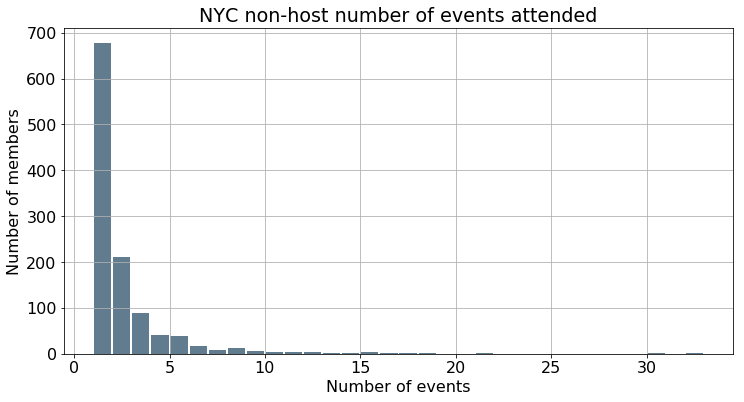

In [186]:
fig, ax = plt.subplots(figsize=(12, 6))
rsvp_yes_host_excluded['response'].hist(grid=True, bins=32, rwidth=0.9, color='#607c8e', ax=ax);
ax.set_xlabel('Number of events'); ax.set_ylabel('Number of members');
ax.set_title('NYC non-host number of events attended');

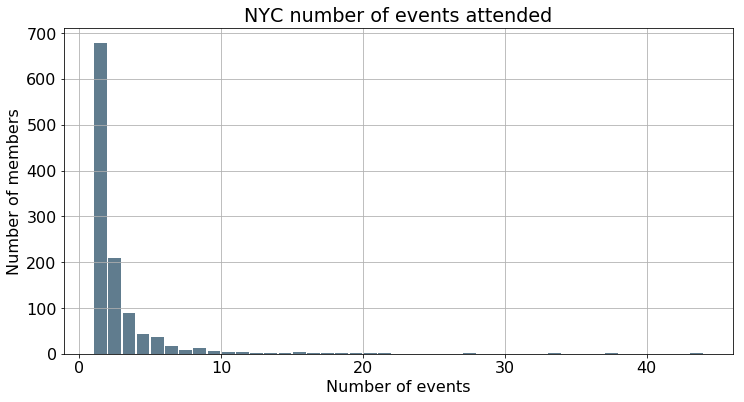

In [187]:
fig, ax = plt.subplots(figsize=(12, 6))
rsvp_yes_host_included['response'].hist(grid=True, bins=43, rwidth=0.9, color='#607c8e', ax=ax);
ax.set_xlabel('Number of events'); ax.set_ylabel('Number of members');
ax.set_title('NYC number of events attended');

## Open Questions:
1. How many organizers does each chapter have?  and does that impact the number of events they have?
2. Can we predict which chapters are "inactive" based on when their last event is or how many people sign up for their events?

## Meetup Member enrollment. 

In [ ]:
max_returned = 200
join_dates_all = pd.DataFrame()

for ix, row in active_meetups.drop_duplicates().iterrows():
    meetup_url = row['Meetup Link']
    print(meetup_url)
    urlname = meetup_url.split('meetup.com/')[1].split('/')[0]
            
    ## Get the Meetup Group details.
    group_info = client.GetGroup({'urlname': urlname})
    group_id = group_info.id
    
    total_members = group_info.members
    print('There are {} members'.format(total_members))
    
    date_joined = []
    members = client.GetMembers(group_id=group_id)
    if members.meta['total_count'] > 0:
        for offset in np.arange(int(np.ceil(total_members/max_returned))):
            members = client.GetMembers(group_id=group_id, offset=offset)
            for member in members.results:
                try: 
                    date_joined.append(datetime.fromtimestamp(member.get('joined')/1000.0))
                except:
                    print('{} doesnot have an enrollment date'.format(member['id']))
                    pass

        print('{} member enrollement dates were scraped'.format(len(date_joined)))

        join_dates = pd.DataFrame({'date_joined':date_joined})
        join_dates = join_dates.sort_values('date_joined').reset_index(drop=True)
        join_dates[urlname] = 1
        join_dates = join_dates.set_index('date_joined')
        join_dates = join_dates.groupby(pd.Grouper(freq='D')).count().copy()

        join_dates_all = join_dates_all.join(join_dates)

In [183]:
join_dates_all.head()

,pyladiessf,NYC-PyLadies,seattle-pyladies,pyladieslondon,PyLadiesTW,PyLadies-Pune,PyLadies-Berlin,dc-pyladies,Chicago-PyLadies,pyladies-atx,...,pyladiescz,PyLadiesAMS,PyLadiesEdinburgh,Helsinki-Pyladies,pyladies-vienna,PyLadies-BH-Meetup,PyLadiesGrandRapids,PyLadies-Hamburg,PyLadiesCaxiasdoSul,PyLadies-Arlington
date_joined,,,,,,,,,,,,,,,,,,,,,
2012-04-04,15,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-05,8,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-06,2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-07,13,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-08,5,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
def plot_orientations(member_ranking, join_data):
    color = matplotlib.cm.viridis_r(np.linspace(0, 1, len(join_data.columns)))

    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    
    join_data.cumsum()[join_data.columns[member_ranking[0]:member_ranking[1]]].plot(ax=ax, lw=4, color=color, alpha=0.8);    
    ax.set_ylim(ymin=0);
    ax.grid();
    ax.set_xlabel('Date Joined', fontsize=25);
    ax.set_ylabel('Number of Members', fontsize=25);
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Meetup Chapter', ncol=2);

In [53]:
plot_data = join_dates_all.copy()
interactive(plot_orientations, 
            member_ranking=ipywidgets.IntRangeSlider(value=[0, 1], 
                                                     min=0, max=len(plot_data.columns), 
                                                     description='ranking by total members:', style = {'description_width': 'initial'},
                                                     layout=ipywidgets.Layout(width='50%')), 
            join_data=fixed(plot_data))

interactive(children=(IntRangeSlider(value=(0, 1), description='ranking by total members:', layout=Layout(widt…

## Open Questions
1. How does meetup event frequency affect enrollment? 
2. How many members have not been to any events? Are we more likely to have repeat attendees?
3. Use Neo4j graph database to analyze connections between member interests based on their other meetup groups.
4. Group event types and determine which events are more popular.
5. Use event location details to determine how it affects attendance. 
6. Best day of the week for events?
7. **Timeseries analysis** Are there any predictors for meetup growth (eg. facebook prophet)
8. Use analysis of Twitter data. 

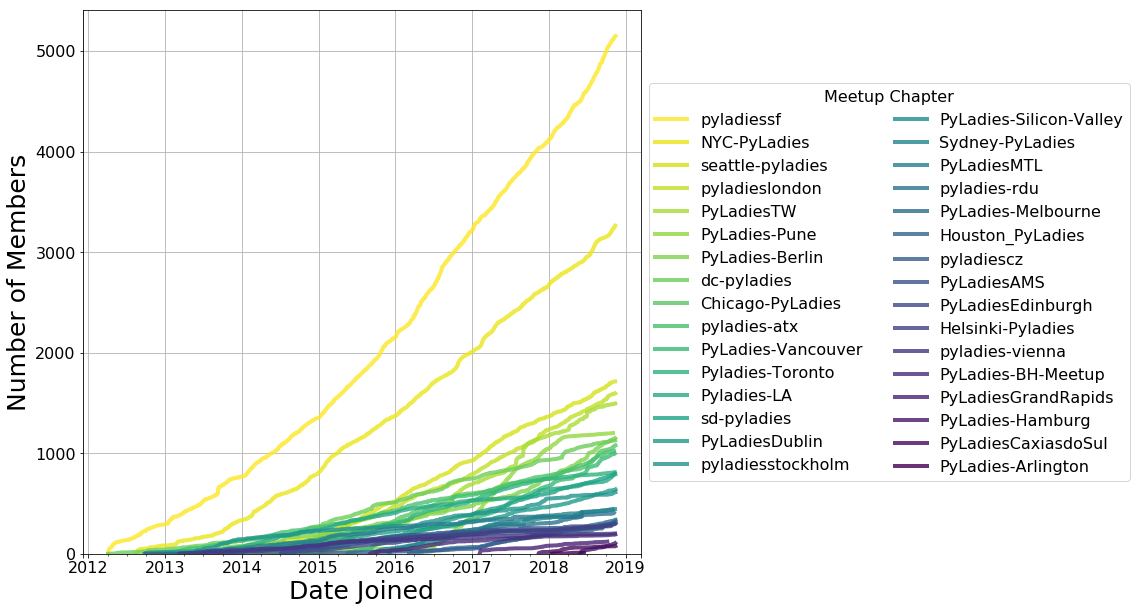

In [119]:
color = matplotlib.cm.viridis_r(np.linspace(0, 1, len(join_dates_all.columns)))

fig, ax = plt.subplots(figsize=(10,10))
join_dates_all.cumsum().plot(ax=ax, lw=4, color=color, alpha=0.8);
ax.set_ylim(ymin=0);#, ymax=3500); 
ax.grid();
ax.set_xlabel('Date Joined', fontsize=25);
ax.set_ylabel('Number of Members', fontsize=25);
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, title='Meetup Chapter');

# NYC Members.

In [188]:
meetup_url = 'NYC-PyLadies'
urlname = meetup_url

In [26]:
## Get the Meetup Group details.
group_info = client.GetGroup({'urlname': urlname})
group_id = group_info.id

29/30 (10 seconds remaining)


In [262]:
max_returned = 200
nyc_members = pd.DataFrame()

urlname = 'NYC-PyLadies'
            
## Get the Meetup Group details.
group_info = client.GetGroup({'urlname': urlname})
group_id = group_info.id
    
total_members = group_info.members
print('There are {} members'.format(total_members))
    
for offset in np.arange(int(np.ceil(total_members/max_returned))):
    members = client.GetMembers(group_id=group_id, offset=offset)
    for member in members.results:
        nyc_members = nyc_members.append(member, ignore_index=True)

29/30 (10 seconds remaining)
There are 3295 members
28/30 (10 seconds remaining)
27/30 (7 seconds remaining)
26/30 (4 seconds remaining)
25/30 (1 seconds remaining)
29/30 (10 seconds remaining)
28/30 (7 seconds remaining)
27/30 (4 seconds remaining)
26/30 (1 seconds remaining)
29/30 (10 seconds remaining)
28/30 (6 seconds remaining)
27/30 (3 seconds remaining)
26/30 (0 seconds remaining)
29/30 (10 seconds remaining)
28/30 (7 seconds remaining)
27/30 (3 seconds remaining)
29/30 (10 seconds remaining)
28/30 (6 seconds remaining)


In [266]:
nyc_members['joined'] = nyc_members['joined'].apply(lambda x: datetime.fromtimestamp(x/1000.))
nyc_members['visited'] = nyc_members['visited'].apply(lambda x: datetime.fromtimestamp(x/1000.))
nyc_members['id'] = nyc_members['id'].astype('int')

In [10]:
#nyc_members.to_csv('nyc_members.gz', compression='gzip')
n#yc_members = pd.read_csv('nyc_members.gz', compression='gzip')

In [282]:
mems = set(nyc_members.id.unique()) 
attend = set(nyc_attendees.member_id.unique())